<a href="https://colab.research.google.com/github/pascuapablo/CEIA/blob/master/scripts/computer_vision/Clase_3_Transfer_Learning_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
  -O cats_and_dogs_filtered.zip

--2020-11-21 14:22:35--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.9.208, 172.217.2.112, 172.217.164.144, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.9.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   179MB/s    in 0.4s    

2020-11-21 14:22:36 (179 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [2]:
! unzip -q cats_and_dogs_filtered.zip

In [3]:
train_dir = "cats_and_dogs_filtered/train"
validation_dir = "cats_and_dogs_filtered/validation"

## Primero como siempre importamos los datos

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Ahora importamos la red y los pesos de la red VGG16

In [5]:
from tensorflow.keras.applications import VGG16

vgg_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 0s 0us/step


In [6]:
vgg_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

## Setear los parámetros del modelo base a no entrenable

In [7]:
vgg_base.trainable=False 

### Ahora hay que agregar las últimas capas de la red:

In [8]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(vgg_base)
# agregar el final de la red
# una capa flatten
# una capa densa de 256 elementos
# una capa sigmoidea
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

### Entrenamos el modelo

In [9]:
from tensorflow.keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])


In [10]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=3,
      validation_data=validation_generator,
      validation_steps=50)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/3
100/100 [==============================] - 18s 181ms/step - loss: 0.5924 - acc: 0.6930 - val_loss: 0.4558 - val_acc: 0.8170
Epoch 2/3
100/100 [==============================] - 18s 181ms/step - loss: 0.4887 - acc: 0.7765 - val_loss: 0.3817 - val_acc: 0.8400
Epoch 3/3
100/100 [==============================] - 18s 180ms/step - loss: 0.4388 - acc: 0.8165 - val_loss: 0.3484 - val_acc: 0.8640


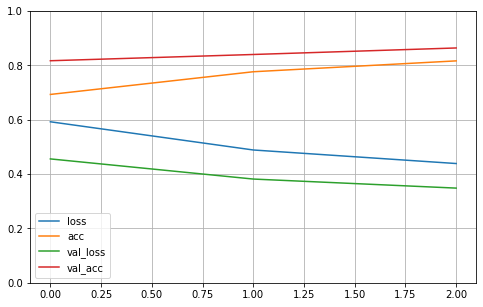

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

# TAREA: Hacer lo mismo con ResNet50:

In [ ]:
from tensorflow.keras.applications import ResNet50
base_resnet = ResNet50(
    include_top=False,
    weights="imagenet",
    # input_tensor=None,
    input_shape=(150, 150, 3),
    pooling=None,
    classes=1000,
  )

base_resnet.summary()


In [32]:
model2 = models.Sequential()
model2.add(base_resnet)
model2.add(layers.Flatten())
model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))
model2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
flatten_7 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               6553728   
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 129       
Total params: 30,141,569
Trainable params: 30,088,449
Non-trainable params: 53,120
_________________________________________________________________


In [33]:
model2.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = model2.fit_generator(
      train_generator,
      epochs=3,
      validation_data=validation_generator,
      )


Epoch 1/3
100/100 [==============================] - 22s 222ms/step - loss: 0.1800 - acc: 0.9240 - val_loss: 1.2571 - val_acc: 0.6650
Epoch 2/3
100/100 [==============================] - 21s 214ms/step - loss: 0.1218 - acc: 0.9590 - val_loss: 0.5015 - val_acc: 0.8380
Epoch 3/3
100/100 [==============================] - 21s 213ms/step - loss: 0.1257 - acc: 0.9570 - val_loss: 0.3183 - val_acc: 0.9120


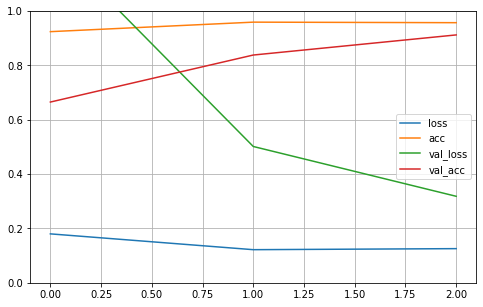

In [34]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()